In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from windrose import WindroseAxes


# Load the data

In [3]:
df = pd.read_csv('../data/togo-dapaong_qc.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
df = df.sort_index()
print(df.shape)

(525600, 18)


# Summary Statistics & Missing-Value Report

In [4]:
print("The description of the dataset is:")
print(df.describe())

print("\n")
#Missing values
print("The number of missing values in each column is:")
print(df.isna().sum())
print("\n")
# Missing columns
print("Columns with >5% null:")
vals = df.isna().sum()

# Convert series to DataFrame and compute missing percentage
vals = vals.to_frame(name="Missing Count").assign(
    Missing_Percentage=lambda x: (x["Missing Count"] / len(df)) * 100
)

# Keep only columns with missing values, sorted by percentage
vals = vals[vals["Missing Count"] > 0].sort_values(by="Missing_Percentage", ascending=False)

# Display missing value summary
print("Missing Value Summary:")
if vals.empty:
    print("No missing values found.")
else:
    print(vals)

# Identify columns with more than 5% missing values
high_null_cols = vals.query("Missing_Percentage > 5").index.tolist()
print(f"\nColumns with >5% missing values: {high_null_cols}")


The description of the dataset is:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588      27.751788      55.013160       2.368093   
std       307.932510       4.758023      28.778732       1.462668   
min         0.000000      14.900000       3.300000       0.000000  

# Outlier Detection & Basic Cleaning

In [5]:
num_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]
z_score = np.abs(stats.zscore(df[num_cols], nan_policy="omit"))
outlier_flags = (z_score > 3).any(axis=1)
print(f"Number of outlier samples flagged: {outlier_flags.sum()}")


Number of outlier samples flagged: 9251


## Imputation

In [6]:
for col in num_cols:
    df.loc[outlier_flags, col] = df[col].median()

#check for outliers
# Compute Z-scores and flag outliers (|Z| > 3)
num_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]

z_score = np.abs(stats.zscore(df[num_cols], nan_policy="omit"))
outlier_flags = (z_score > 3).any(axis=1)
print(f"Number of outlier samples flagged: {outlier_flags.sum()}")

Number of outlier samples flagged: 4695


## Export

In [7]:
df_clean = df[~outlier_flags].copy()
df_clean.to_csv("../data/togo_clean.csv", index=False)
print("Cleaned data exported")

Cleaned data exported


# Time Series Analysis

    Line Chart (Hourly/Daily Trends)

/home/bini/Documents/repos/solar-challenge-week1/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


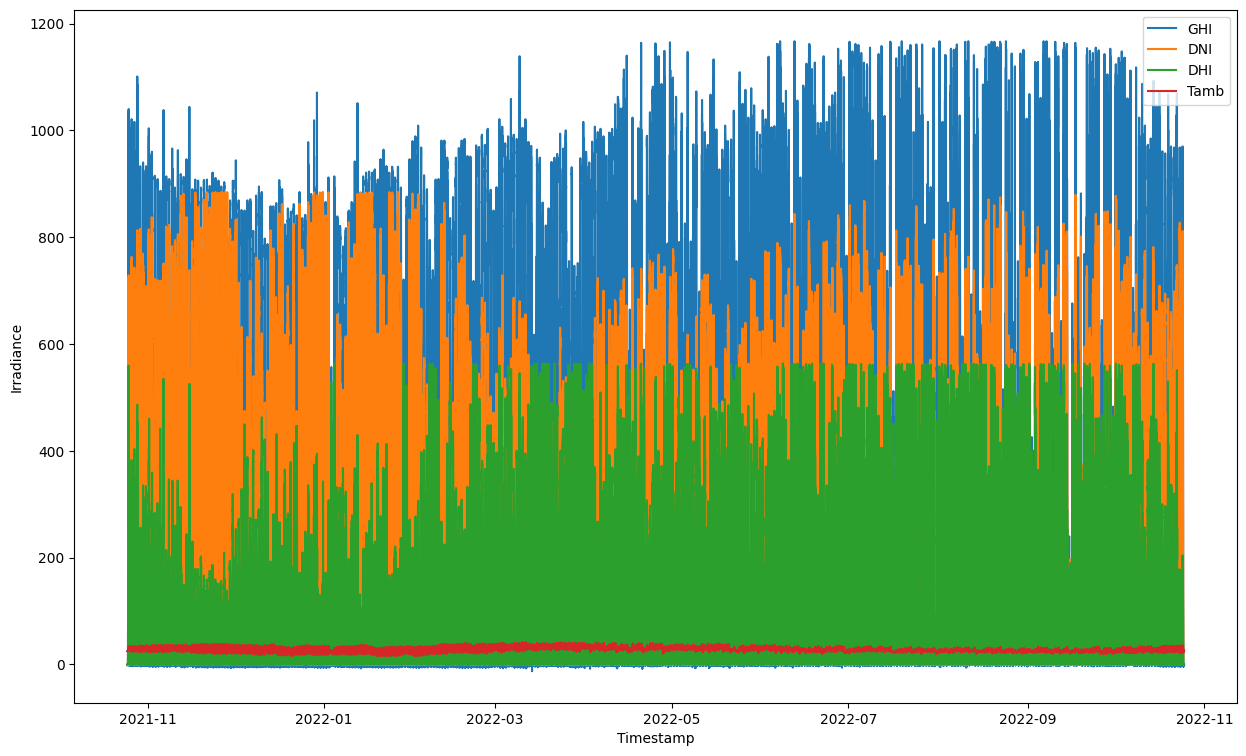

In [8]:
# Solar Irradiance over time
vars = ['GHI', 'DNI', 'DHI', 'Tamb']
plt.figure(figsize=(15, 9))
for var in vars:
    plt.plot(df_clean.index, df_clean[var], label=var)
plt.xlabel("Timestamp")
plt.ylabel("Irradiance")
plt.legend()
plt.show()

    Daily Trend

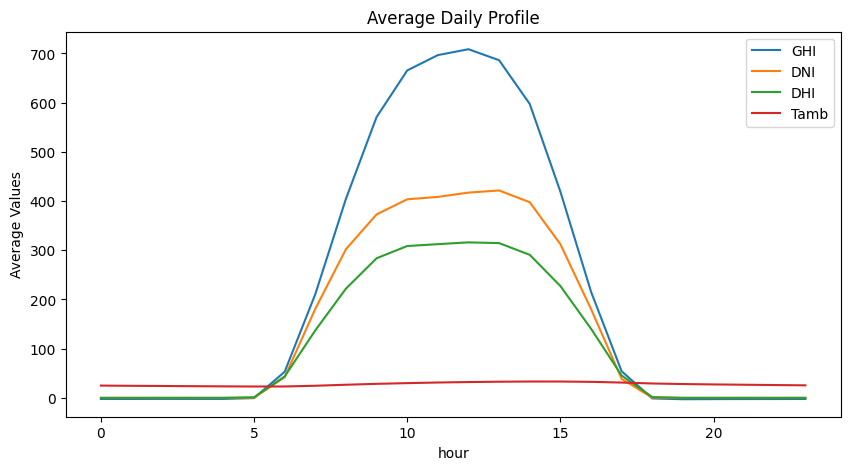

In [9]:
# Hourly Profile
df_clean['hour'] = df_clean.index.hour
hourly_mean = df_clean.groupby('hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

hourly_mean.plot(kind='line', figsize=(10, 5), title='Average Daily Profile')
plt.ylabel('Average Values')
plt.show()

    Monthly Trend

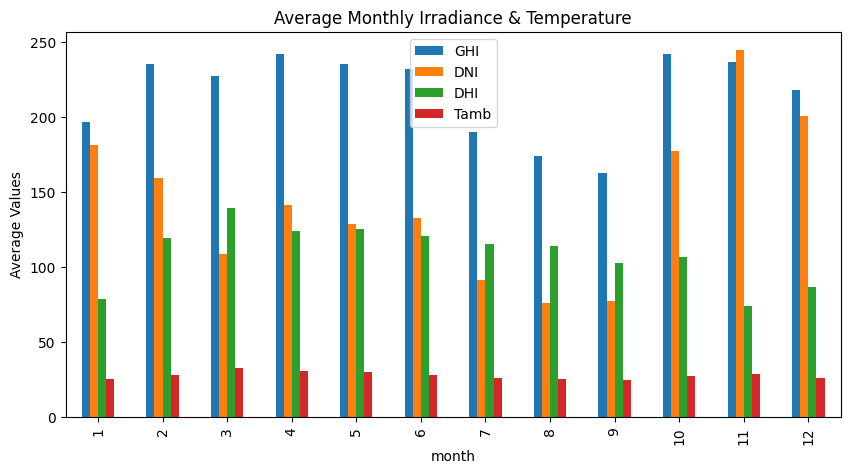

In [10]:
df_clean['month'] = df_clean.index.month
monthly_mean = df_clean.groupby('month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

monthly_mean.plot(kind='bar', figsize=(10, 5), title='Average Monthly Irradiance & Temperature')
plt.ylabel('Average Values')
plt.show()

    Anomaly visualization

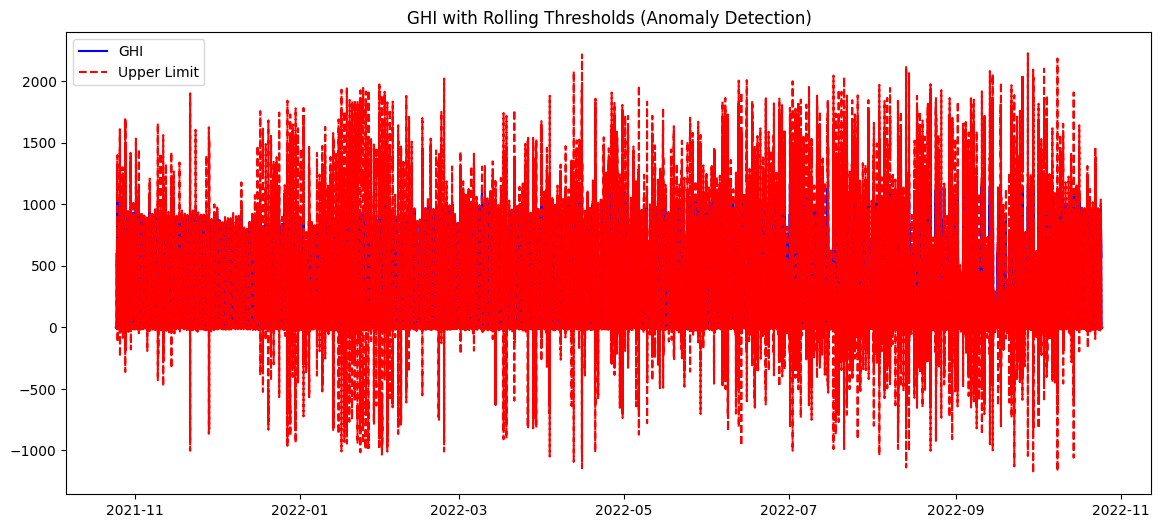

In [11]:
win = 24
mean = df_clean["GHI"].rolling(win).mean()
std = df_clean["GHI"].rolling(win).std()
upper_bar = mean + 3 * std
lower_bar = mean - 3 * std

plt.figure(figsize=(14,6))
plt.plot(df_clean.index, df_clean['GHI'], label='GHI', color='blue')
plt.plot(df_clean.index, upper_bar, color='red', linestyle='--', label='Upper Limit')
plt.plot(df_clean.index, lower_bar, color='red', linestyle='--')
plt.title('GHI with Rolling Thresholds (Anomaly Detection)')
plt.legend()
plt.show()

# Cleaning Impact


Average Module Irradiance Pre/Post Cleaning
1 = Cleaning Occurred, 0 = No Cleaning
                ModA        ModB
Cleaning                        
0         211.218287  205.105866
1         506.700000  505.455147


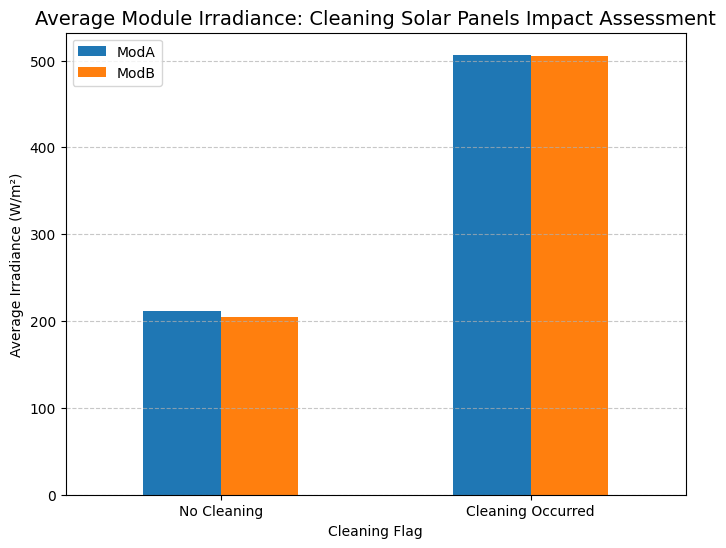

In [12]:
cleaning_impact = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean()

print("\nAverage Module Irradiance Pre/Post Cleaning")
print("1 = Cleaning Occurred, 0 = No Cleaning")
print(cleaning_impact)

# Plotting the impact
plt.figure(figsize=(8, 6))
cleaning_impact.plot(kind='bar', ax=plt.gca())

plt.title('Average Module Irradiance: Cleaning Solar Panels Impact Assessment', fontsize=14)
plt.ylabel('Average Irradiance (W/m²)')
plt.xlabel('Cleaning Flag')
plt.xticks([0, 1], ['No Cleaning', 'Cleaning Occurred'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

                     ModA        ModB
Cleaning_Flag                        
Post-Clean     211.372578  205.262699
Pre-Clean      226.144375  219.568588


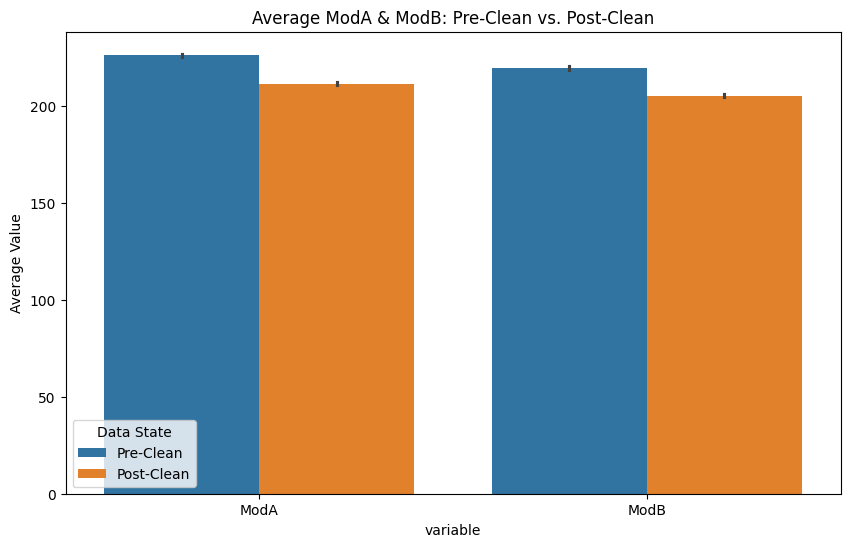

In [13]:
df_raw = pd.read_csv(f"../data/togo-dapaong_qc.csv")
df_new = pd.read_csv(f'../data/togo_clean.csv')

# Add flags
df_raw['Cleaning_Flag'] = 'Pre-Clean'
df_new['Cleaning_Flag'] = 'Post-Clean'

# Combine into one DataFrame for comparison
df_combined = pd.concat([df_raw, df_new])

# Group by flag and calculate mean
cleaning_impact = df_combined.groupby('Cleaning_Flag')[['ModA', 'ModB']].mean()
print(cleaning_impact)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_combined.melt(id_vars='Cleaning_Flag', value_vars=['ModA', 'ModB']),
    x='variable', 
    y='value', 
    hue='Cleaning_Flag',
)
plt.title('Average ModA & ModB: Pre-Clean vs. Post-Clean')
plt.ylabel('Average Value')
plt.legend(title='Data State')
plt.show()

# Correlation & Relationship Analysis

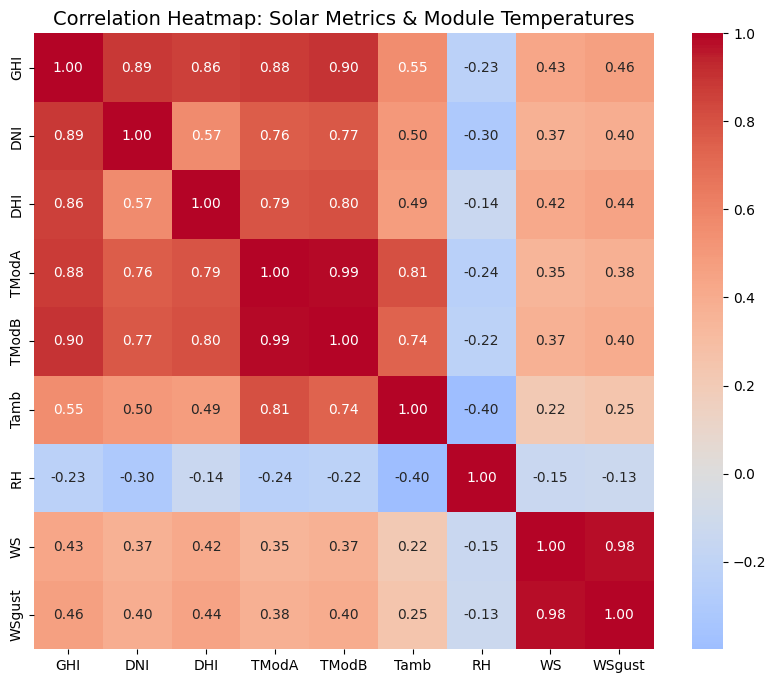

In [14]:
cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH', 'WS', 'WSgust']
corr_matrix = df_clean[cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Heatmap: Solar Metrics & Module Temperatures', fontsize=14)
plt.show()

    Wind vs. Solar Irradiance (WS, WSgust, WD vs. GHI)

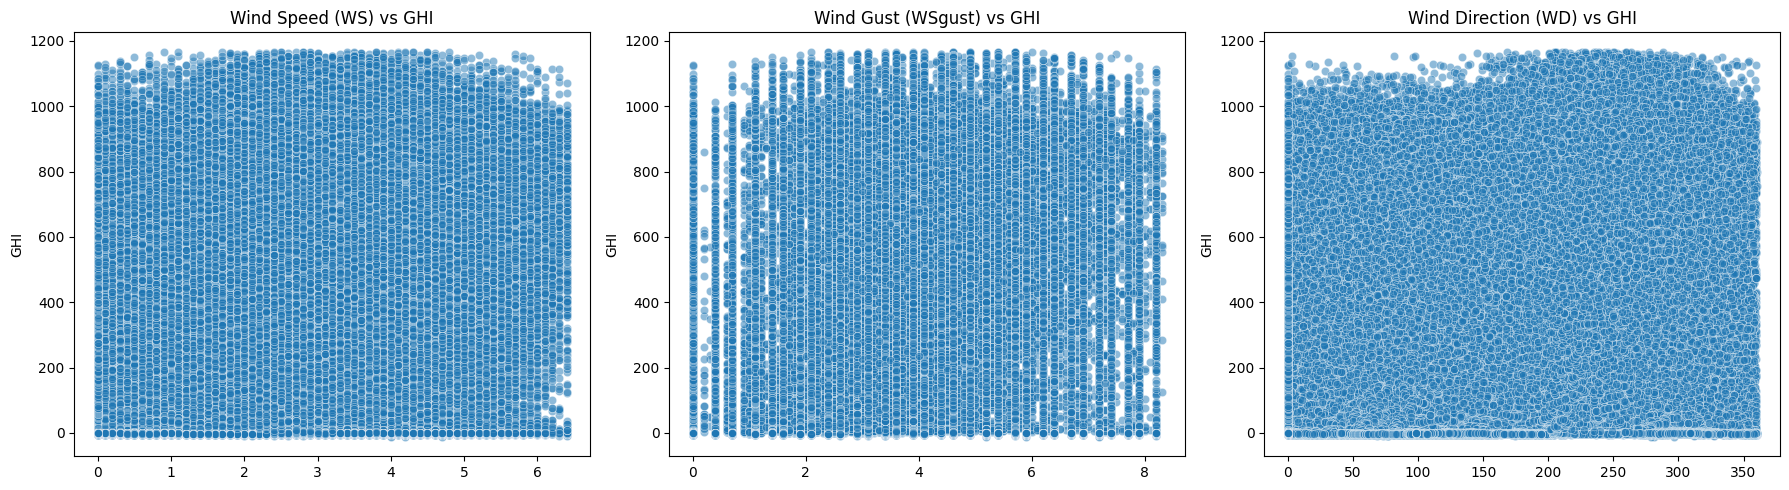

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df_clean, x='WS', y='GHI', ax=axes[0], alpha=0.5)
axes[0].set_title('Wind Speed (WS) vs GHI')

sns.scatterplot(data=df_clean, x='WSgust', y='GHI', ax=axes[1], alpha=0.5)
axes[1].set_title('Wind Gust (WSgust) vs GHI')

sns.scatterplot(data=df_clean, x='WD', y='GHI', ax=axes[2], alpha=0.5)
axes[2].set_title('Wind Direction (WD) vs GHI')

for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('GHI')
plt.tight_layout()
plt.show()

     Humidity vs. Temperature/Radiation (RH vs. Tamb or GHI)

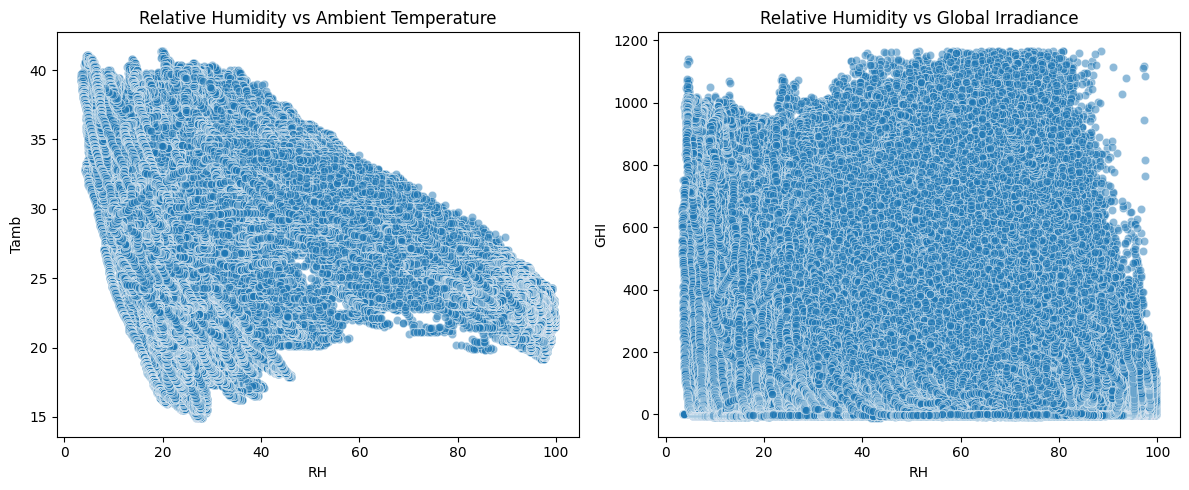

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(data=df_clean, x='RH', y='Tamb', ax=axes[0], alpha=0.5)
axes[0].set_title('Relative Humidity vs Ambient Temperature')

sns.scatterplot(data=df_clean, x='RH', y='GHI', ax=axes[1], alpha=0.5)
axes[1].set_title('Relative Humidity vs Global Irradiance')


plt.tight_layout()
plt.show()

# Wind & Distribution Analysis

    Wind rose or radial bar plot of WS/WD.   

<Figure size 800x800 with 0 Axes>

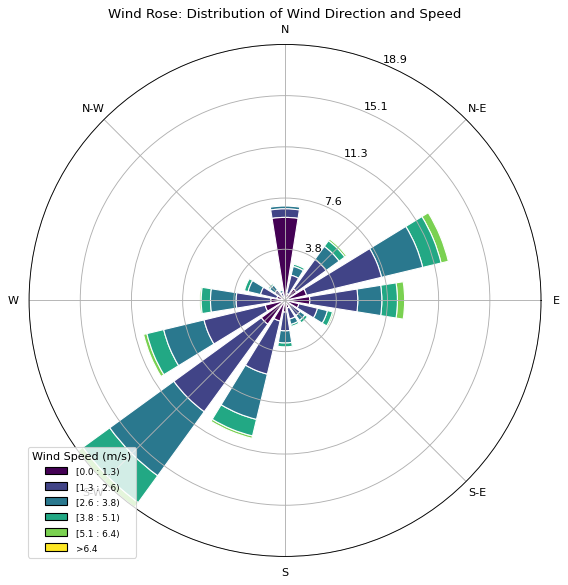

In [17]:
plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax()
ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_title('Wind Rose: Distribution of Wind Direction and Speed')
ax.set_legend(title='Wind Speed (m/s)')
plt.show()

    Histograms for GHI and one other variable

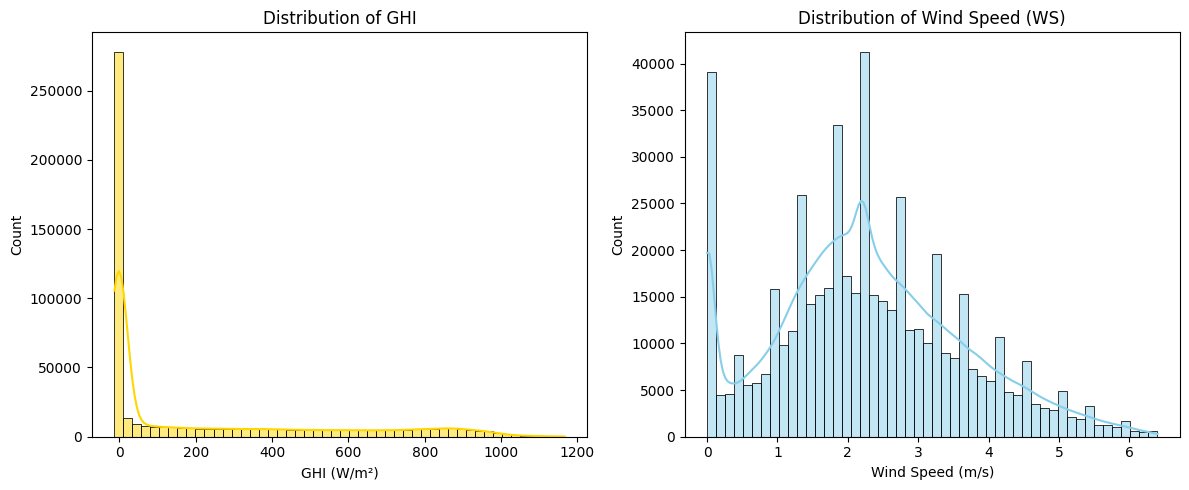

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_clean['GHI'], bins=50, kde=True, ax=axes[0], color='gold')
axes[0].set_title('Distribution of GHI')
axes[0].set_xlabel('GHI (W/m²)')

sns.histplot(df_clean['WS'], bins=50, kde=True, ax=axes[1], color='skyblue')
axes[1].set_title('Distribution of Wind Speed (WS)')
axes[1].set_xlabel('Wind Speed (m/s)')

plt.tight_layout()
plt.show()

# Temperature Analysis

<Axes: xlabel='RH', ylabel='Tamb'>

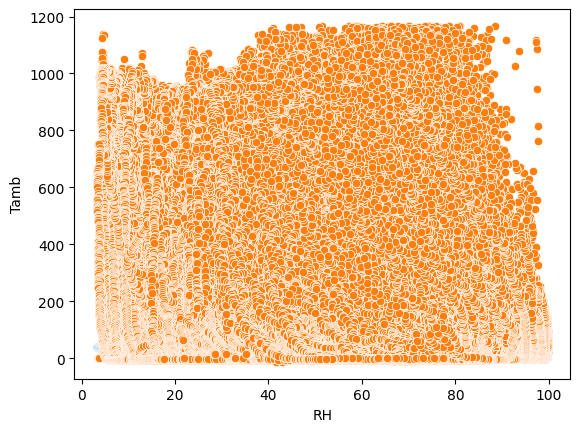

In [19]:
sns.scatterplot(data = df_clean, x = 'RH', y = 'Tamb')
sns.scatterplot(data = df_clean, x = 'RH', y = 'GHI')

# Bubble Chart

    Bubble Chart: GHI vs. Tamb (Bubble Size = RH)

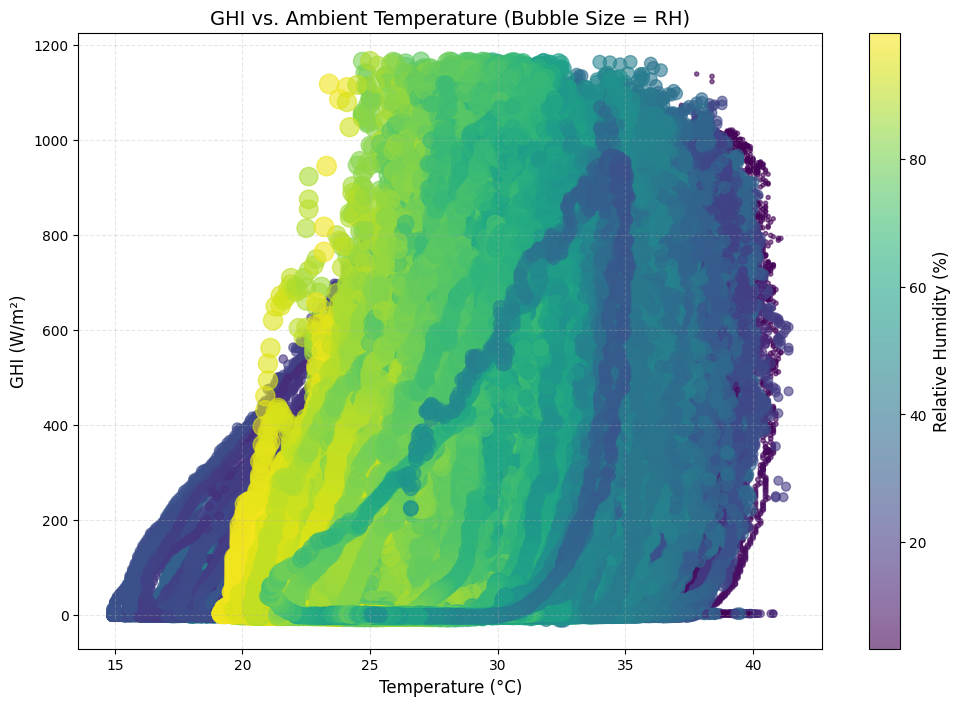

In [20]:
# Ensure data is clean and numeric
df_clean = df_clean.dropna(subset=['GHI', 'Tamb', 'RH'])  # Drop missing values
df_clean[['GHI', 'Tamb', 'RH']] = df_clean[['GHI', 'Tamb', 'RH']].apply(pd.to_numeric, errors='coerce')

# Create bubble chart
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    x=df_clean['Tamb'],
    y=df_clean['GHI'],
    s=df_clean['RH'] * 2,  # Scale RH for visibility (adjust multiplier as needed)
    c=df_clean['RH'],      # Color bubbles by RH
    alpha=0.6,
    cmap='viridis'
)

# Add labels and colorbar
plt.title('GHI vs. Ambient Temperature (Bubble Size = RH)', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('GHI (W/m²)', fontsize=12)
cbar = plt.colorbar(scatter)
cbar.set_label('Relative Humidity (%)', fontsize=12)

# Add grid for readability
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

    Bubble Chart: GHI vs. Tamb (Bubble Size = BP)

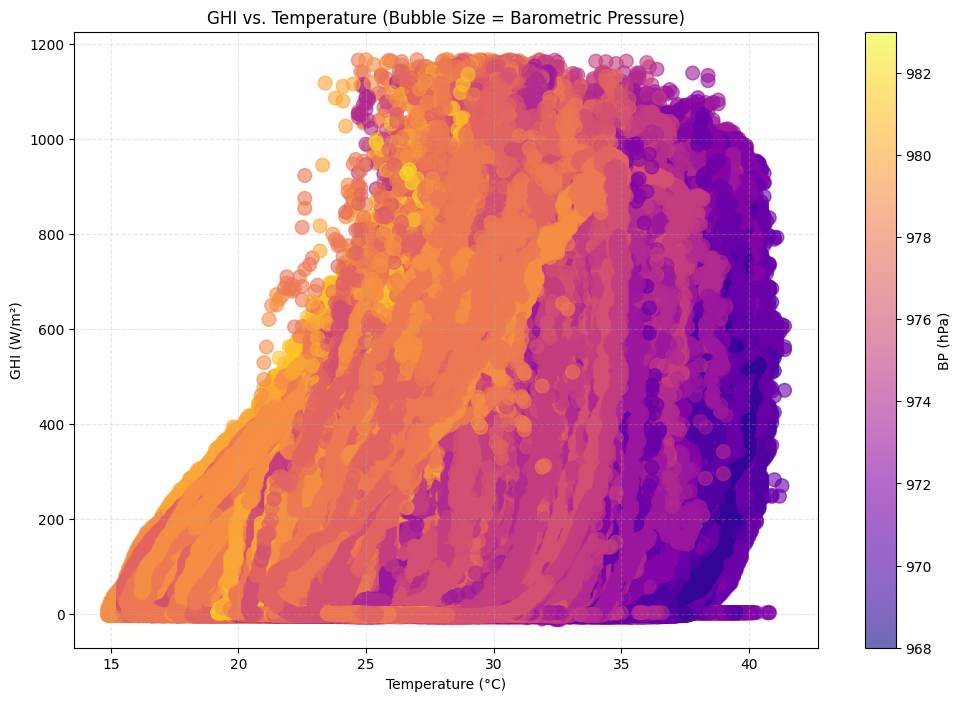

In [21]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    x=df_clean['Tamb'],
    y=df_clean['GHI'],
    s=df_clean['BP'] * 0.1,  # Scale BP appropriately
    c=df_clean['BP'],
    alpha=0.6,
    cmap='plasma'            # Different colormap for clarity
)
plt.title('GHI vs. Temperature (Bubble Size = Barometric Pressure)')
plt.xlabel('Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.colorbar(label='BP (hPa)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()